# Principal Component Analysis
pca is a mathmatical operation that finds the most important features, or combination of features, contributing to your end value. In our case, we search for sensors that indicate, or indicate against, a future machine failure.

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [11]:
#read our cleaned csv into a pandas dataframe
df = pd.read_csv('clean-df.csv')

#The index got reset, lets put the timestamp back
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)


### We can take a look at some of the sensors to better understand the real-time changes and break downs.

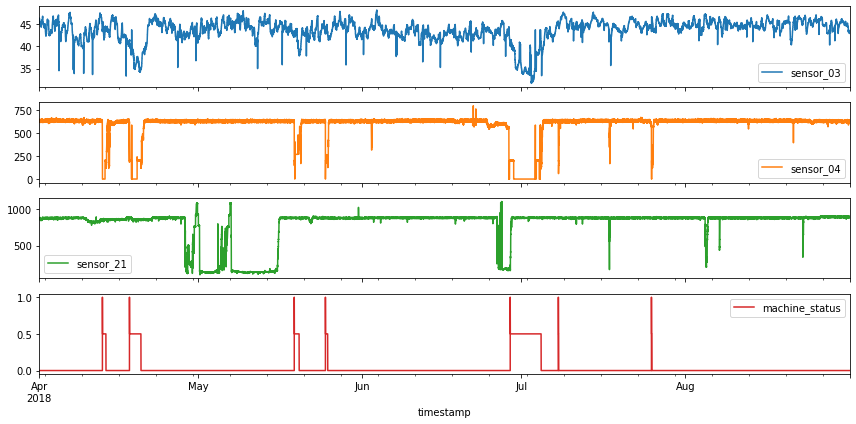

In [12]:
df_subset = df[['sensor_03', 'sensor_04', 'sensor_21', 'machine_status']]

#Matplotlib allows us to define we want to use subplots for each columns (not all the lines on one plot) and the overall figure size.
df_subset.plot( kind='line',figsize=(12,6),subplots=True)
plt.tight_layout()
plt.show()

### Let's keep track of when those failures above happens. 

In [13]:
failure_times = df[df['machine_status'] == 1]
print("Failure times:")
failure_times

Failure times:


,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,...,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,machine_status
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-12 21:55:00,53.342010,52.821180,43.402775,202.52603,49.79289,3.219039,16.890910,16.869210,15.082470,35.530850,...,39.583330,36.979160,50.78125,50.92593,51.21528,50.63657,46.006940,409.143500,121.52780,1.0
2018-04-18 00:30:00,42.534720,47.699650,41.449650,206.03876,60.30106,12.304690,15.154800,14.185470,13.867190,28.304880,...,28.645830,29.947916,42.70833,34.72222,31.53935,34.43287,33.275460,59.895830,44.56018,1.0
2018-05-19 03:18:00,47.265630,52.734370,43.446180,200.11574,66.14643,13.592300,15.914350,15.147570,14.793110,43.998860,...,32.291660,31.250000,39.06250,35.01157,37.90509,39.06250,45.428240,144.675900,49.76852,1.0
2018-05-25 00:30:00,47.482640,51.475693,42.795135,612.15280,67.30158,14.062500,16.608800,15.943290,15.596060,27.092980,...,212.760400,176.822900,202.34370,65.68287,57.87037,127.89350,153.935200,155.381900,65.68287,1.0
2018-06-28 22:00:00,40.190970,45.225690,40.190970,201.36862,0.00000,11.335360,15.270540,15.183740,15.118630,2.002474,...,23.177082,24.739580,32.29166,28.06713,28.06713,29.51389,29.224537,29.224537,29.51389,1.0
2018-07-08 00:11:00,45.138890,52.907990,45.355900,500.00000,1.40131,0.028935,0.036169,0.036169,0.007234,25.977650,...,35.416660,32.812500,36.19791,37.32639,35.30093,38.19444,43.402780,99.537030,44.84954,1.0
2018-07-25 14:00:00,45.833332,52.994790,43.880210,420.50345,72.52040,14.185470,16.247110,15.697340,15.053530,36.717480,...,35.416660,36.458330,51.30208,52.10200,52.66204,67.12963,43.981480,230.324100,69.73380,1.0


### For our model, we'll need to designate which parts of the data should train the model and which should be used for testing. The validation split is a way of testing and checking against overfitting, without using the actual test data.

### A common practice is to just split your data randomly, or by a defined percent. However, we want to make sure each split has at least one failure and recovery.

In [14]:
#Define the failures and specifcally the first two
timestamps = list(failure_times.index)
first_failure = timestamps[0]
second_failure = timestamps[1]

#Create a time buffer for our sensors to recover
two_hours = pd.Timedelta(seconds=60 * 120)

#Split our large dataframe
#Validation will include all the data up to the first failure (plus to hours)
#Testing will include the following data up until the second failure (plus to hours)
#Training data includes eveything else
df_val = df.loc[:(first_failure + two_hours), :]
df_test = df.loc[(first_failure + two_hours):(second_failure + two_hours), :]
df_train = df.loc[(second_failure + two_hours):, :]

#Get a better look at the results
print('Validation size:')
print(str(df_val.shape)+ '  ' + str(round(len(df_val) / len(df)*100,2)) + '%')
print('Test size:')
print(str(df_test.shape)+ '  ' + str(round(len(df_test) / len(df)*100,2)) + '%')
print('Train size:')
print(str(df_train.shape)+ '  ' + str(round(len(df_train) / len(df)*100,2)) + '%')


Validation size:
(17276, 49)  7.84%
Test size:
(7356, 49)  3.34%
Train size:
(195690, 49)  88.82%


### For better training accuracy we should try and avoid big discrepancies between the sensor averages. Normalizing all the columns does the trick

In [42]:
np.matrix(scaled_train).transpose

<function matrix.transpose>

In [50]:
#Display original ranges
ranges = pd.DataFrame([{'min':i,'max':j} for i, j in zip(df_train.min(), df_train.max())])
col_names = df_train.max().keys()
ranges.index = col_names
display(ranges.transpose())

sensor_names = df_train.columns
min_max_scaler = MinMaxScaler(feature_range=(0, 1))

#finds the variables needed to transform our data to the [0,1] range we defined above
scaler = min_max_scaler.fit(df_train[sensor_names])

#tranforms each dataframe
scaled_val = scaler.transform(df_val[sensor_names])
scaled_test = scaler.transform(df_test[sensor_names])
scaled_train = scaler.transform(df_train[sensor_names])

column_arrays = np.array(scaled_train).T
ranges = pd.DataFrame([{'min':k.min(),'max':k.max()} for k in column_arrays])
ranges.index = col_names
display(ranges.transpose())


,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,...,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,machine_status
min,0.00000,33.15972,31.64062,2.798032,0.00000,0.014468,0.00000,0.028935,0.0,0.00000,...,20.83333,22.135416,24.479166,25.752316,26.331018,26.331018,27.19907,26.331018,26.62037,0.0
max,56.72743,56.03299,48.22049,800.000000,99.99988,22.251160,23.59664,24.348960,25.0,76.10686,...,420.31250,374.218800,408.593700,1000.000000,320.312500,370.370400,303.53010,561.632000,464.40970,1.0


,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,...,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,machine_status
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### We're reading to run PCA

In [16]:
pca = PCA(n_components=scaled_train.shape[1]).fit(scaled_train)

### Starting with a single feature, and each time a new feature is added, we will check to see how much variance within machine_status can be explained by the changes in the subset of features.

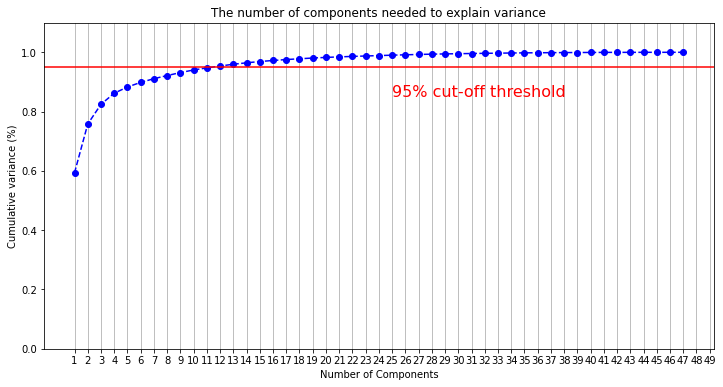

In [17]:
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, df_train.shape[1]-1, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(1, df_train.shape[1]+1, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(25, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

### 95% accuracy is good enough for us

### Now, lastly, let's get those actual values we are correlating to the variance. Each Principal component contributes a different amount to the end goal, so we will include the ones the contribute most.

In [18]:
num_pc_to_include = 12

def transform_df_pca(pca, data, scaled_data):
    """Reduce the number of features in the training data by the parameter num_features_to_include.

    :param pca: The PCA for the training data
    :type: PCA
    :param df_data: data dataframe
    :type: Pandas DataFrame
    :param scaled_data: Array of scaled data
    :type: ndarray
    :param num_pc_to_include: Number of features to include.  Currently, this number is determined
    by the num of PC's that were chosen by the PCA to reach 95% ( sum of explained_variance_ratio)
    :type: int
    
    :return: DataFrame with data that has been scaled and whose dimensions have been reduced.  This DataFrame has
    the same index as the param df_data
    :type: Pandas DataFrame
    """
    #Transform our raw data with the fitted pca numbers
    data_transformed = pca.transform(scaled_data)  # ndarray
    df_transformed = pd.DataFrame(data_transformed)
    
    #Rename the columns
    pcs = ['pc' + str(i + 1) for i in range(pca.n_components_)]
    df_transformed.columns = pcs

    #Provide our new numbers the same timestamps and machine_status as the original dataset
    df_transformed.index = data.index
    df_transformed = df_transformed[pcs[:num_pc_to_include]]
    df_transformed['machine_status'] = data['machine_status'].values
    

    return df_transformed

#Transform each dataset
df_train_pca = transform_df_pca(pca, df_train, scaled_train)
df_test_pca = transform_df_pca(pca, df_test, scaled_test)
df_val_pca = transform_df_pca(pca, df_val, scaled_val)

#### We can now think of our rows as vectors currently contributing to directional changes in machine_status

In [22]:
df_train_pca

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,machine_status
timestamp,,,,,,,,,,,,,
2018-04-18 02:30:00,-0.128641,1.410076,0.194306,0.446849,-0.380950,-0.105999,0.068558,0.171579,-0.020029,-0.089618,0.042070,-0.047774,0.5
2018-04-18 02:31:00,-0.121417,1.417852,0.173372,0.437315,-0.392624,-0.086322,0.044358,0.173201,-0.005303,-0.070027,0.031231,-0.048875,0.5
2018-04-18 02:32:00,-0.126777,1.422542,0.161684,0.427027,-0.401568,-0.081803,0.015023,0.177289,-0.005135,-0.052899,0.032534,-0.057414,0.5
2018-04-18 02:33:00,-0.119010,1.417832,0.174297,0.433716,-0.394863,-0.097057,0.022641,0.175827,-0.011169,-0.062327,0.041721,-0.052791,0.5
2018-04-18 02:34:00,-0.128034,1.416018,0.173724,0.433398,-0.393999,-0.087187,0.039675,0.172969,-0.011848,-0.064721,0.038477,-0.048676,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 23:55:00,-0.441923,-0.375973,0.266187,0.139460,0.038957,-0.088413,0.134479,-0.084517,-0.035249,0.013163,0.017339,-0.048815,0.0
2018-08-31 23:56:00,-0.438829,-0.379715,0.245282,0.147314,0.051209,-0.094082,0.130096,-0.091493,-0.042291,0.020168,0.036902,-0.059774,0.0
2018-08-31 23:57:00,-0.436908,-0.382310,0.240055,0.149143,0.064410,-0.094249,0.131447,-0.095969,-0.032398,0.019445,0.032589,-0.056891,0.0
